# WIRC+Pol Modulation Sequence Tutorial #

This tutorial is to show you how to reduce WIRC+Pol data obtained after March 2019 using the new awesome modulator to obtain q,u,p and theta. 

In this tutorial we assume that you have already been through the two other tutorials, named WIRC+Pol_Single_File_Tutorial and WIRC+Pol_Dataset_Reduction_Tutorial. These tutorials will touch on installation and give you a good instroduction as to formats of WIRC+Pol data. 

Here we assume that you already have run the pipeline to extract spectra on a dataset, but have yet to combine them via single differencing (in time) or double-differencing. 

In [1]:
import numpy as np
import glob
import wirc_drp.wirc_object as wo
from wirc_drp.utils import source_utils
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

### Read in the files - Tutorial Dataset ###

For the purpose of this tutorial, we are providing you with spectra and hwp angles in .np files. That we read in here. Below we show a commented out example of how you would get these same inputs from a WIRC+Pol dataset.

We assume here that the group of spectra have already been aligned (see the Dataset tutorial). 

In [2]:
all_spec_cube = np.load("sample_data/Elia2-14_HWP_Spectra.npy")
hwp_ang = np.load("sample_data/Elia2-14_HWP_Angles.npy")
nfiles = all_spec_cube.shape[0]

### Read in the files - Normal Operations ###

The three following commented out boxes give you an example of how to read in the data for this tutorial from normal wircpol_object fits files. You would do something like this when reducing your own data. 


In [3]:
### Read in the files. 
#fnames = np.sort(glob.glob("/path_to_your_files_here/*.fits"))
#nfiles = len(fnames)
#print("Found {} files".format(nfiles))

In [4]:
### Read in the first one to get the spectra size
#test= wo.wirc_data(wirc_object_filename=fnames[0],verbose=False)

### Create a list to read the spectra into
# all_spec_cube = []

### And the HWP angles
#hwp_ang = np.zeros([nfiles])
#time = np.zeros([nfiles])

In [5]:
# all_spec_cube = []
# for im in np.arange(nfiles):
#     wirc_object = wo.wirc_data(wirc_object_filename=fnames[im],verbose=False)
#     wirc_object.source_list[0].get_broadband_polarization(mode="aperture_photometry")
#     hwp_ang[im] = wirc_object.header['HWP_ANG']
    
#     #Shift the spectra to the side because of the filter tilt. 
#     #The value of -3 used here might not be ideal, but we'll see. 
#     spectra[im,1,:] = np.roll(spectra[im,1,:],-3)
#     spectra[im,3,:] = np.roll(spectra[im,3,:],-3)
    
#     wirc_object.source_list[0].trace_spectra[1,1,:] = np.roll(wirc_object.source_list[0].trace_spectra[1,1,:],-3)
#     wirc_object.source_list[0].trace_spectra[3,1,:] = np.roll(wirc_object.source_list[0].trace_spectra[3,1,:],-3)
    
#     all_spec_cube.append(wirc_object.source_list[0].trace_spectra)

# all_spec_cube = np.array(all_spec_cube)

## Plot the spectra and make sure they're aligned and ready to go

(-2000, 30000)

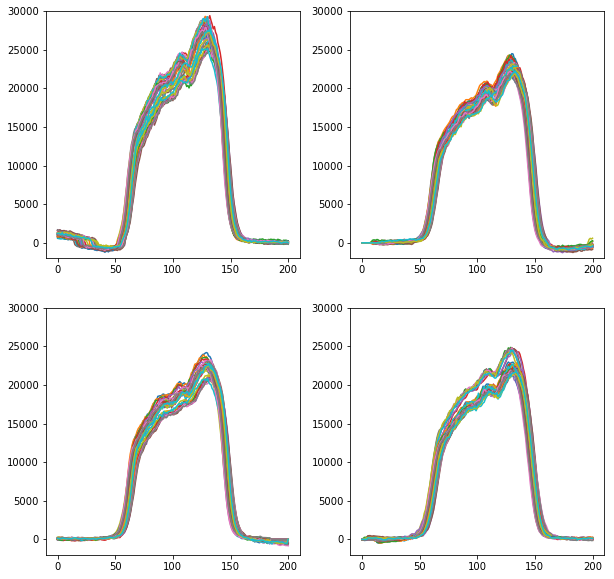

In [6]:
fig,axes = plt.subplots(2,2,figsize=(10,10))

for im in np.arange(nfiles):
    axes[0,0].plot(all_spec_cube[im,0,1,:])
    axes[0,1].plot(all_spec_cube[im,1,1,:])
    axes[1,0].plot(all_spec_cube[im,2,1,:])
    axes[1,1].plot(all_spec_cube[im,3,1,:])

axes[0,0].set_ylim(-2000,30000)
axes[0,1].set_ylim(-2000,30000)
axes[1,0].set_ylim(-2000,30000)
axes[1,1].set_ylim(-2000,30000)

Things look good here, so let's move on. If the spectra aren't aligned, then go back to the last tutorial and remind yourself how to align a spectral cube. 

## Calculate _q_ and _u_ using single differencing in time for each trace. 

Here we create an array of _q_ and _u_ by first doing a single difference of each trace in time. The following function automatically sorts the input data based on the HWP angles that you pass to it and subtracts the appropriate spectra from each other (i.e. 45 degrees from 0 degrees, and 67.5 degrees from 22.5 degrees).

In [15]:
q,u,q_err,u_err,q_ind,u_ind = source_utils.compute_qu_for_obs_sequence(all_spec_cube,hwp_ang,run_alignment=False)

The _q_ and _u_ arrays that are output contain the _q_ and _u_ measurements from all fours traces, organized in pairs corresponding to the two matching traces in any given image (i.e. the Upper_Left-Bottom_Right or Bottom_Left-Upper_Right pair). To understand better here what we mean, take a look at the shape of _q_. 

In [16]:
q.shape

(20, 2, 201)

The dimensions are [n_measurements,which_trace,wavelength], where the which_trace dimension represents the two two different traces in a pair. To know which pair of traces a given <i>n_measurements<i> index corresponds to, you have to look at the q_ind parameter. 

In [17]:
q_ind

array([[2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

Where the numbering here correponds to which traces is in the <i>which_trace<i> in the _q_ and _u_ arrays

### Now calculate _p_ and _$\theta$_

In [18]:
p = np.sqrt(q**2+u**2)
theta = 0.5*np.degrees(np.arctan2(u,q))
theta[theta<0] += 180

### Now we can plot our results

(0, 180)

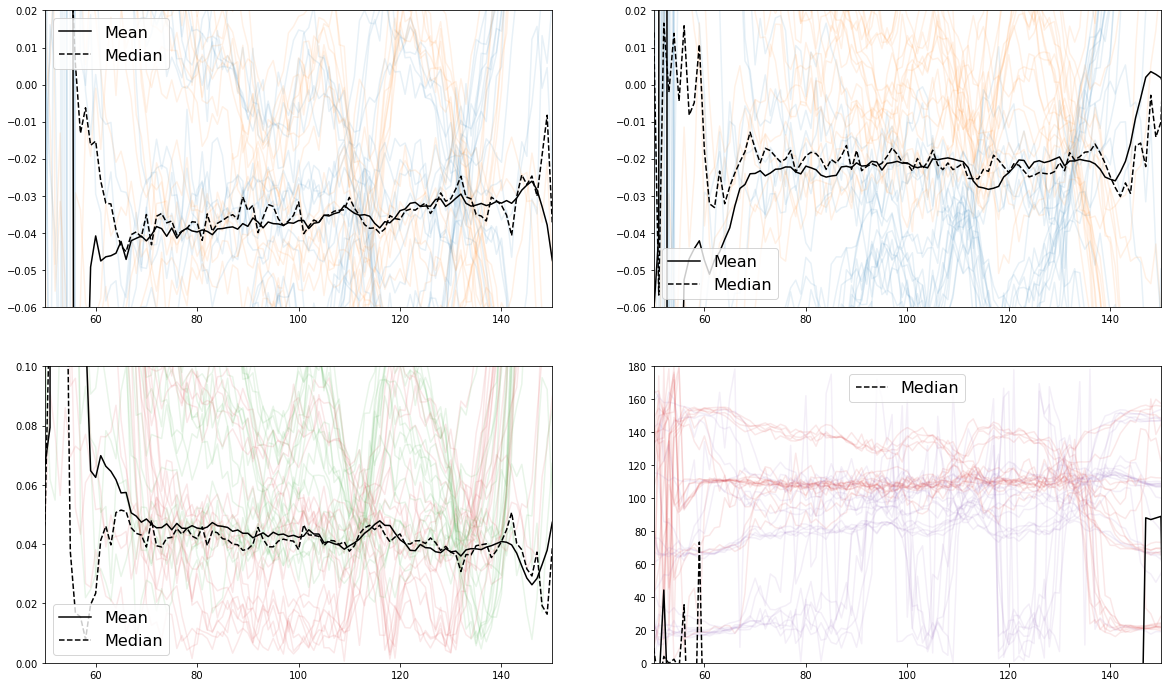

In [21]:
fig,axes = plt.subplots(2,2,figsize=(20,12))

n_q = q.shape[0]

q_mean = np.nanmean(q,axis=(0,1))
u_mean = np.nanmean(u,axis=(0,1))
p_mean = np.sqrt(q_mean**2+u_mean**2)
theta_mean = 0.5*np.degrees(np.arctan2(u_mean,q_mean))


q_median = np.nanmedian(q,axis=(0,1))
u_median = np.nanmedian(u,axis=(0,1))
p_median = np.sqrt(q_median**2+u_median**2)
theta_median = 0.5*np.degrees(np.arctan2(u_median,q_median))
# p_dd = np.sqrt(q_dd**2+u_dd**2)
# theta_dd = 0.5*np.degrees(np.arctan2(u_dd,q_dd))
# theta_dd[theta_dd < 0] +=180

for i in range(n_q):
    #Plot Q
    axes[0,0].plot(q[i,0,:],'C0',alpha=2/n_q)
    axes[0,0].plot(q[i,1,:],'C1',alpha=2/n_q)
    
    #Plot U
    axes[0,1].plot(u[i,0,:],'C0',alpha=2/n_q)
    axes[0,1].plot(u[i,1,:],'C1',alpha=2/n_q)
    
    #Plot p
    axes[1,0].plot(p[i,0,:],'C2',alpha=2/n_q)
    axes[1,0].plot(p[i,1,:],'C3',alpha=2/n_q)
    
    #Plot theta
    axes[1,1].plot(theta[i,0,:],'C3',alpha=2/n_q)
    axes[1,1].plot(theta[i,1,:],'C4',alpha=2/n_q)

axes[0,0].plot(q_mean,'k',label="Mean")    
axes[0,1].plot(u_mean,'k',label="Mean")   
axes[1,0].plot(p_mean,'k',label="Mean")
axes[1,1].plot(theta_mean,'k')

axes[0,0].plot(q_median,'k--',label="Median")    
axes[0,1].plot(u_median,'k--',label="Median")    
axes[1,0].plot(p_median,'k--',label="Median")    
axes[1,1].plot(theta_median,'k--',label="Median")

axes[0,0].legend(fontsize=16)
axes[0,1].legend(fontsize=16)
axes[1,0].legend(fontsize=16)
axes[1,1].legend(fontsize=16)

axes[0,0].set_xlim(50,150)
axes[0,1].set_xlim(50,150)
axes[1,0].set_xlim(50,150)
axes[1,1].set_xlim(50,150)

axes[0,0].set_ylim(-0.06,0.02)
axes[0,1].set_ylim(-0.06,0.02)
axes[1,0].set_ylim(0,0.1)
axes[1,1].set_ylim(0,180)

Wow, these plots look messy until we combine them into a mean or median! One of the reasons here is that we haven't yet carried out any double differencing

### By taking the mean in axis=1 we apply a double-difference

In [22]:
q_dd = np.nanmean(q,axis=1)
u_dd = np.nanmean(u,axis=1)
p_dd = np.sqrt(q_dd**2+u_dd**2)
theta_dd = 0.5*np.degrees(np.arctan2(u_dd,q_dd))
theta_dd[theta_dd < 0] +=180

(0, 180)

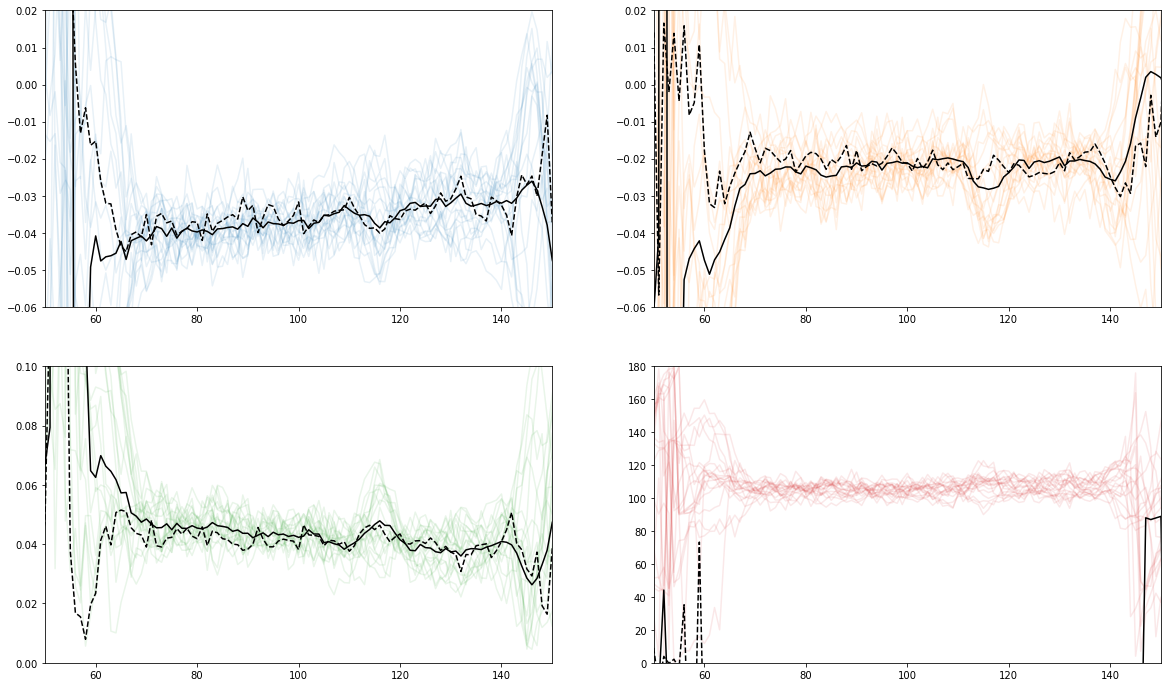

In [23]:
n_qdd = q_dd.shape[0]


fig,axes = plt.subplots(2,2,figsize=(20,12))
for i in range(n_qdd):
    #Plot Q
    axes[0,0].plot(q_dd[i,:],'C0',alpha=2/n_q)
    
    #Plot U
    axes[0,1].plot(u_dd[i,:],'C1',alpha=2/n_q)
    
    #Plot p
    axes[1,0].plot(p_dd[i,:],'C2',alpha=2/n_q)
    
    #Plot theta
    axes[1,1].plot(theta_dd[i,:],'C3',alpha=2/n_q)

axes[0,0].plot(q_mean,'k')    
axes[0,1].plot(u_mean,'k')   
axes[1,0].plot(p_mean,'k')
axes[1,1].plot(theta_mean,'k')

axes[0,0].plot(q_median,'k--')    
axes[0,1].plot(u_median,'k--')   
axes[1,0].plot(p_median,'k--')
axes[1,1].plot(theta_median,'k--')

axes[0,0].set_xlim(50,150)
axes[0,1].set_xlim(50,150)
axes[1,0].set_xlim(50,150)
axes[1,1].set_xlim(50,150)

axes[0,0].set_ylim(-0.06,0.02)
axes[0,1].set_ylim(-0.06,0.02)
axes[1,0].set_ylim(0,0.1)
axes[1,1].set_ylim(0,180)

TODO: Some comment about how the median and mean are the same as before and that's as expected. 

### And now with an error range on the final Q and U

In [ ]:
q_dd = np.nanmean(q,axis=1)
u_dd = np.nanmean(u,axis=1)
p_dd = np.sqrt(q_dd**2+u_dd**2)
theta_dd = 0.5*np.degrees(np.arctan2(u_dd,q_dd))
theta_dd[theta_dd < 0] +=180

In [ ]:
q_mean_err = np.